In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


## Importing the data from BIG CSV

In [6]:
data = pd.read_csv(
    'Raw data/openipf-2024-12-28-acdecc3a.csv',
    dtype={'BodyweightKg': 'float64', 'TotalKg': 'float64'},
    low_memory=False
)

In [7]:
# Parse the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')


In [8]:
# Filter for raw, full-power meets (SBD), males, and international meets from 2011 onwards
filtered_data = data[
    (data['Event'] == 'SBD') &              # Full power (SBD)
    (data['Equipment'] == 'Single-ply') &         # Raw lifting
    (data['Sex'] == 'M') &
    (data['BodyweightKg'] >= 37.5)&
    (data['Federation'].isin(['IPF', 'EPF'])) &  # International meets only
    (data['Date'] >= '2011-01-01')
    # (data['Date'] <= '2024-06-15')
    # (data['Date'] <= '2020-04-30')
]

In [9]:
# Ensure necessary columns are present and drop missing values
filtered_data = filtered_data[['Name', 'BodyweightKg', 'TotalKg', 'WeightClassKg', 'Federation', 'Date','MeetName']].dropna()

filtered_data['MeetName'] = filtered_data['MeetName'].str.strip().str.lower()

In [10]:
filtered_data.loc[:, 'Name'] = (
    filtered_data['Name']
    .str.strip()  # Remove leading/trailing spaces
    .str.lower()  # Convert to lowercase for uniformity
)

In [11]:

# Retain the highest total per person per weight class
filtered_data = filtered_data.loc[
    filtered_data.groupby(['Name', 'WeightClassKg'])['TotalKg'].idxmax()
].reset_index(drop=True)


In [12]:
# Count the number of rows where WeightClassKg is '120+'
count_120_plus = (filtered_data['WeightClassKg'] == '120+').sum()

# Display the result
print(f"Number of lifters in the 120+ weight class: {count_120_plus}")


Number of lifters in the 120+ weight class: 275


In [13]:
# Save the filtered data to a CSV
filtered_data.to_csv('filtered_data_equipped_man.csv', index=False)
print("Filtered data saved as 'filtered_data_ipf_epf.csv'.")


Filtered data saved as 'filtered_data_ipf_epf.csv'.


In [14]:


# World records male 2024
world_records = {
     '59': 669.5, '66': 710.5, '74': 836.0, '83': 861.0, '93': 901.0,
    '105': 940.5, '120': 978.5, '120+': 1152.5
}




In [15]:
# World records male 2024 equipp
world_records = {
     '59': 765, '66': 820, '74': 908, '83': 945, '93': 1064,
    '105': 1092.5, '120': 1132.5, '120+': 1275.5
}

In [16]:
# World records male 2020
world_records = {
    '59': 669.5, '66': 705.5, '74': 790.5, '83': 833, '93': 853.5,
    '105': 895.5, '120': 978.5, '120+': 1105.5
}

In [17]:

# World records female 2020
world_records = {'47': 407.5, '52': 432.5, '57': 473.5,
                 '63': 543.5, '72': 543.5, '84': 613, '84+': 671.5
}

In [18]:
# world records female 2024
world_records = {'47': 433.5, '52': 481, '57': 519.5,
                 '63': 557.5, '69': 600, '76': 613, '84': 647, '84+': 731
}

In [19]:
# filtering for gold standard data
filtered_data['WeightClassKg'] = filtered_data['WeightClassKg'].astype(str)
gold_standard_data = filtered_data[
    filtered_data.apply(
        lambda row: row['TotalKg'] >= 0.84 * world_records.get(row['WeightClassKg'], np.inf), axis=1
    )
]

In [20]:
# Standardize 'Name' column to ensure proper deduplication
gold_standard_data.loc[:, 'Name'] = (
    gold_standard_data['Name']
    .str.strip()  # Remove leading/trailing spaces
    .str.lower()  # Convert to lowercase for uniformity
)

In [21]:
# Deduplicate to retain only the top total for each lifter
# Deduplicate to retain only the top total for each lifter per weight class
gold_standard_data = gold_standard_data.loc[
    gold_standard_data.groupby(['Name', 'WeightClassKg'])['TotalKg'].idxmax()
].reset_index(drop=True)


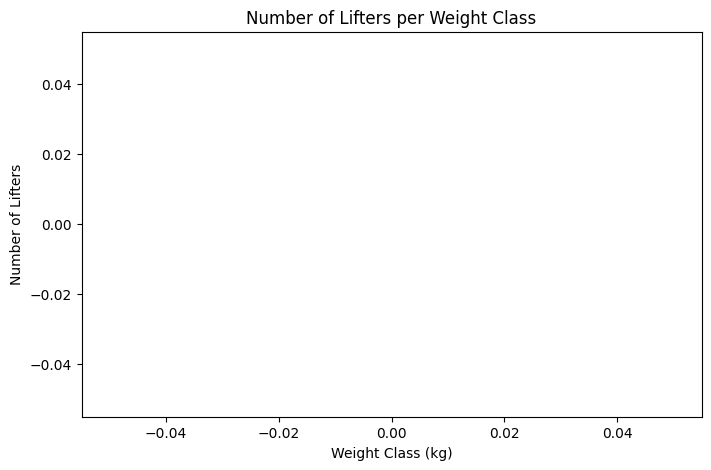

In [22]:
# Count the number of lifters per weight class
weight_class_counts = gold_standard_data['WeightClassKg'].value_counts()

# Convert to a DataFrame for better display
weight_class_table = weight_class_counts.reset_index()
weight_class_table.columns = ['WeightClassKg', 'GoldenSamplesCount']

# Sort the table by GoldenSamplesCount in descending order
weight_class_table = weight_class_table.sort_values(by='GoldenSamplesCount', ascending=False)

# Display the sorted table
import matplotlib.pyplot as plt

# Plot the lifter count per weight class
plt.figure(figsize=(8, 5))
plt.bar(weight_class_table['WeightClassKg'], weight_class_table['GoldenSamplesCount'], color='#f7ce4d')
plt.xlabel('Weight Class (kg)')
plt.ylabel('Number of Lifters')
plt.title('Number of Lifters per Weight Class')
plt.show()



In [23]:
# Save the gold-standard data to a CSV
gold_standard_data.to_csv('gold_standard_before_worlds_female_data_ipf_epf.csv', index=False)
print("Gold standard data saved as 'gold_standard_data_ipf_epf.csv'.")



Gold standard data saved as 'gold_standard_data_ipf_epf.csv'.


#### Data augmentation for the 120+

In [24]:
# Exclude the 120+ weight class from the data
filtered_weight_class_table = weight_class_table[weight_class_table['WeightClassKg'] != '120+']

# Calculate the average number of lifters for the remaining weight classes
average_lifters_per_weight_class = filtered_weight_class_table['GoldenSamplesCount'].mean()

# Display the average
print(f'Average number of lifters per weight class (excluding 120+): {average_lifters_per_weight_class:.2f}')


Average number of lifters per weight class (excluding 120+): nan


In [25]:
# Filter for the 120+ weight class
lifters = gold_standard_data[gold_standard_data['WeightClassKg'] == '120+']

# Average the TotalKg and BodyweightKg for the 120+ kg class
average_total = lifters['TotalKg'].mean()
average_bodyweight = lifters['BodyweightKg'].mean()

# Print the total weight and the filtered DataFrame
print(f'Total weight of lifters in the 120+ weight class: {average_total} kg')
print(f'average bodyweight of lifters in the 120+ weight class: {average_bodyweight} kg')


Total weight of lifters in the 120+ weight class: nan kg
average bodyweight of lifters in the 120+ weight class: nan kg


In [26]:
# Average number of lifters per weight class (excluding 120+): 87.14
# Total weight of lifters in the 120+ weight class: 1036.15 kg
# average bodyweight of lifters in the 120+ weight class: 166.22899999999998 kg
#
# To augment the data lets add 77 lifters with a total of 1036.15kg and a bodyweight off 166.23 to the data sample used
import pandas as pd
# Set the Bodyweight to 166.23 for each lifter
bodyweight_per_lifter = 166.23
num_lifters = 77

# Create the bodyweight list for each lifter
weights = [bodyweight_per_lifter] * num_lifters

# The TotalKg should be a fixed value (total lifted weight in the competition)
total_kg = [1036.15] * num_lifters  # All lifters have the same total lifted weight

# Create the DataFrame with the necessary columns
names = [f'Lifter{i+1}' for i in range(num_lifters)]  # Generating names as Lifter1, Lifter2, ..., Lifter77
weight_classes = ['120+'] * num_lifters  # All lifters are in the 120+ weight class
federations = ['IPF'] * num_lifters  # All lifters are in the IPF federation
dates = ['2024-12-12'] * num_lifters  # Same date for all lifters
meet_names = ['Worlds'] * num_lifters  # Same meet name for all lifters

# Create the DataFrame
df = pd.DataFrame({
    'Name': names,
    'BodyweightKg': weights,
    'TotalKg': total_kg,
    'WeightClassKg': weight_classes,
    'Federation': federations,
    'Date': dates,
    'MeetName': meet_names
})

# Save the DataFrame to a CSV file
csv_file_path = 'male data/extra120+data'
df.to_csv(csv_file_path, index=False)

csv_file_path  # Return the path to the saved file



'male data/extra120+data'